In [3]:
# prompt: unzip the folder

!unzip -q "/content/Dataset -1.zip" -d "/content/"


In [4]:
import os
import numpy as np
from PIL import Image, ImageFilter
import torchvision
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
version = "dataset_1"
model_name = "vgg16_dataset_1"

In [6]:
torch.cuda.is_available()


True

In [7]:
def load_data(path, test_split, val_split, batch_size, input_size):

    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.Resize((64,64)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}

    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset = torch.utils.data.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=DataLoader(train_dataset,batch_size,shuffle=True)
    data_loader_test=DataLoader(test_dataset,batch_size,shuffle=False)
    data_loader_val=DataLoader(val_dataset,batch_size,shuffle=False)
    return data_loader_train, data_loader_test, data_loader_val

In [9]:
train_loader,test_loader,val_loader=load_data(path=r'/content/Dataset-1',
                                              test_split=0.15,val_split= 0.2,batch_size=16, input_size=[64,64])


In [10]:
model = torchvision.models.vgg16(weights=False, num_classes=4)

optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
num_epochs = 50
train_losses = []
train_accs = []
val_accs = []
val_losses = []


patience = 10
delta = 0.001
best_val_loss = float('inf')
best_model_state_dict = None
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


Epoch 1/50, Train Loss: 10125.3324, Train Accuracy: 44.52%, Validation Loss: 0.5558, Validation Accuracy: 20.60%
Epoch 2/50, Train Loss: 0.9828, Train Accuracy: 48.27%, Validation Loss: 0.0467, Validation Accuracy: 47.16%
Epoch 3/50, Train Loss: 1.0055, Train Accuracy: 50.04%, Validation Loss: 0.0423, Validation Accuracy: 47.25%
Epoch 4/50, Train Loss: 1.6820, Train Accuracy: 58.32%, Validation Loss: 0.0375, Validation Accuracy: 71.49%
Epoch 5/50, Train Loss: 1.2599, Train Accuracy: 62.63%, Validation Loss: 0.0549, Validation Accuracy: 67.67%
Epoch 6/50, Train Loss: 15.7159, Train Accuracy: 63.53%, Validation Loss: 0.0456, Validation Accuracy: 64.30%
Epoch 7/50, Train Loss: 1.3221, Train Accuracy: 63.45%, Validation Loss: 0.0338, Validation Accuracy: 69.01%
Epoch 8/50, Train Loss: 0.8590, Train Accuracy: 64.03%, Validation Loss: 0.0310, Validation Accuracy: 71.67%
Epoch 9/50, Train Loss: 0.7292, Train Accuracy: 66.02%, Validation Loss: 0.3393, Validation Accuracy: 69.98%
Epoch 10/50, T

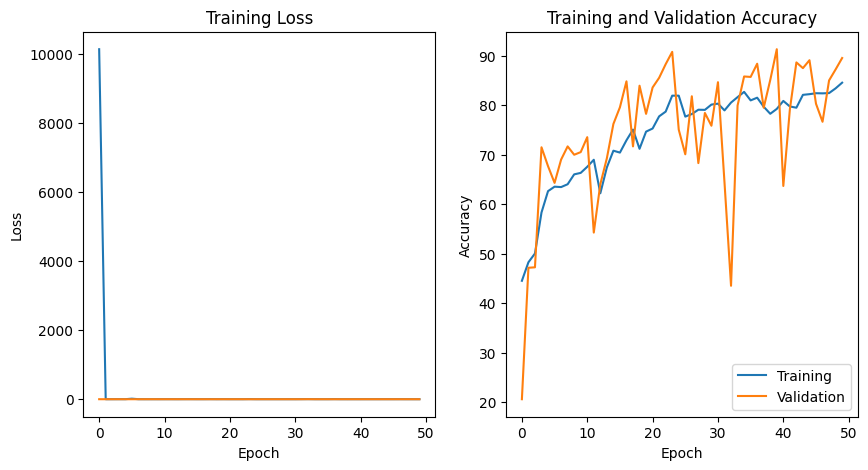

In [12]:
# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Training')
plt.plot(val_losses, label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig(f"train-val_{version}.png",dpi=300)
plt.legend()

In [13]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())  # Predicted probabilities for all classes

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}')
# Save the model
torch.save(model.state_dict(), f'{model_name}.pth')


Test Accuracy: 88.27014218009478


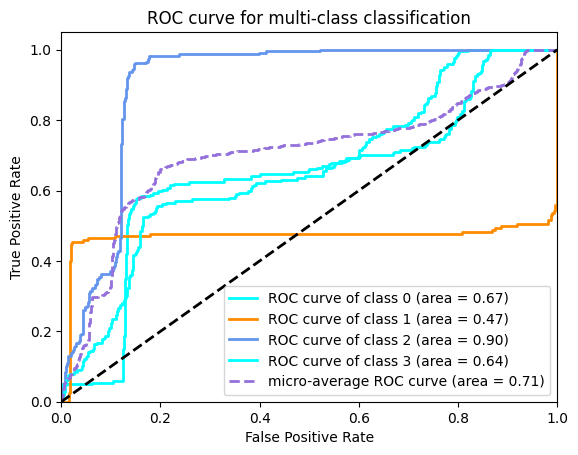

In [15]:
from sklearn.metrics import roc_curve, auc
num_classes = 4
# Convert labels to one-hot encoding
y_true_onehot = label_binarize(y_true, classes=np.arange(num_classes))

# Convert y_pred list to numpy array
y_pred = np.array(y_pred)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot(fpr["micro"], tpr["micro"], color='mediumpurple', lw=lw, linestyle='--',
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class classification')
plt.legend(loc="lower right")
plt.savefig(f"roc{version}.png",dpi=300)
plt.show()

844 844
report:               precision    recall  f1-score   support

      cloudy       0.99      0.92      0.95       221
      desert       0.92      0.98      0.95       170
  green_area       0.87      0.77      0.82       239
       water       0.77      0.88      0.82       214

    accuracy                           0.88       844
   macro avg       0.88      0.89      0.88       844
weighted avg       0.88      0.88      0.88       844



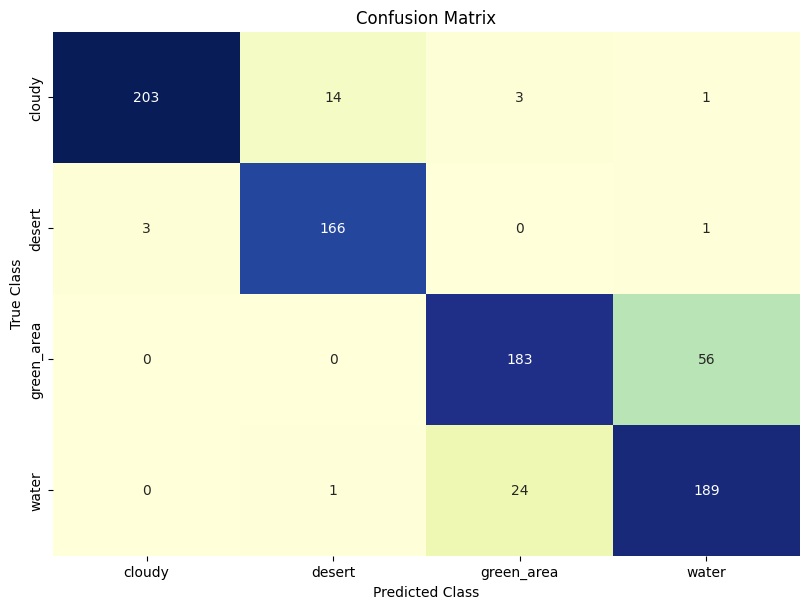

In [17]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    y_true.extend(labels.cpu().numpy())  # transfer tensor to CPU and convert to numpy array

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
print(len(y_true), len(y_pred))
class_names = ('cloudy', 'desert', 'green_area', 'water')
report = classification_report(y_true, y_pred, target_names=class_names)
print(f"report:", report)
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.savefig(f"cf_{version}.png",dpi=300)
plt.show()